In [2]:
%load_ext autoreload
%autoreload 2


In [36]:
# Modify path to find code directory:
import sys
sys.path.append('../code/')

import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import itertools
import time
from matplotlib.lines import Line2D


In [4]:
from structures import *
from utils import initialize_rewards, initialize_values, policy_iteration


In [14]:
custom_legend1 = [Line2D([0], [0], color="#0f0a01", lw=2, label="Inner Connection"),
                Line2D([0], [0], color="#a5a6a9", lw=2, label="Outer Connection"),
                Line2D([0], [0], marker='o', color='w', markerfacecolor="#0098d8", 
                        markersize=15, label="Uninfluenced Agent")]

custom_legend2 = [Line2D([0], [0], color="#0f0a01", lw=2, label="Inner Connection"),
                Line2D([0], [0], color="#a5a6a9", lw=2, label="Outer Connection"),
                Line2D([0], [0], marker='o', color='w', markerfacecolor="#f45844", 
                        markersize=15, label="Influenced"),
                Line2D([0], [0], marker='o', color='w', markerfacecolor="#3dbd5d", 
                        markersize=15, label="Chosen Action"),
                Line2D([0], [0], marker='o', color='w', markerfacecolor="#0098d8", 
                        markersize=15, label="Uninfluenced Agent")]
                        

## Test Problem 1 - Inner Circle, Single Connectivity

In [8]:
agents = [
    Agent(receptivity=np.random.uniform(0.5,1.0), persuasiveness=np.random.uniform(0.5,1.0)),
    Agent(receptivity=np.random.uniform(0.5,1.0), persuasiveness=np.random.uniform(0.5,1.0)),
    Agent(receptivity=np.random.uniform(0.5,1.0), persuasiveness=np.random.uniform(0.5,1.0)),
    Agent(receptivity=np.random.uniform(0.5,1.0), persuasiveness=np.random.uniform(0.5,1.0)),
    Agent(receptivity=np.random.uniform(0.5,1.0), persuasiveness=np.random.uniform(0.5,1.0)),
]

# Add some connections (only use inner circle):
agents[0].outer_circle.append(agents[1].id)
agents[1].outer_circle.append(agents[0].id)
agents[1].inner_circle.append(agents[2].id)
agents[2].inner_circle.append(agents[1].id)
agents[1].inner_circle.append(agents[3].id)
agents[3].inner_circle.append(agents[1].id)
agents[3].outer_circle.append(agents[4].id)
agents[4].outer_circle.append(agents[3].id)

# - REMINDER - Do we want to have connections automatically propagate both ways when specified?

# Build simulation environment:
env = Environment(agents, seed=182)
print(env)


<Environment with 0/5 informed agents>


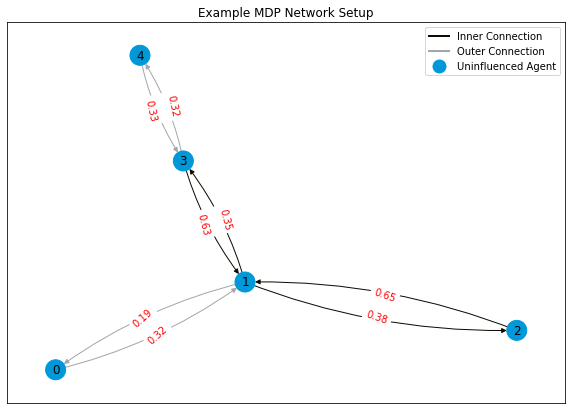

In [10]:
fig, ax1 = plt.subplots(figsize=(10,7))
env.plot_network_graph(ax=ax1)
ax1.set_title("Example MDP Network Setup")
ax1.legend(handles=custom_legend1)
plt.savefig('../data/images/simple_network_example1.png')
plt.show()


In [12]:
env.update_transition_matrix(n_selected=1, model='exhaustive_fast')


# Initialize a policy and MDP problem setup
initial_policy = np.zeros(len(env.state_space), dtype=int)
rewards = initialize_rewards(env.state_space)
values = initialize_values(env.state_space)

optimal_policy = policy_iteration(env, initial_policy, values, rewards, gamma = 0.99, epsilon=1e-8)


20 iterations run - max delta = 0.011030466610540302
40 iterations run - max delta = 1.2455994490068178e-05
60 iterations run - max delta = 8.721344535445041e-09


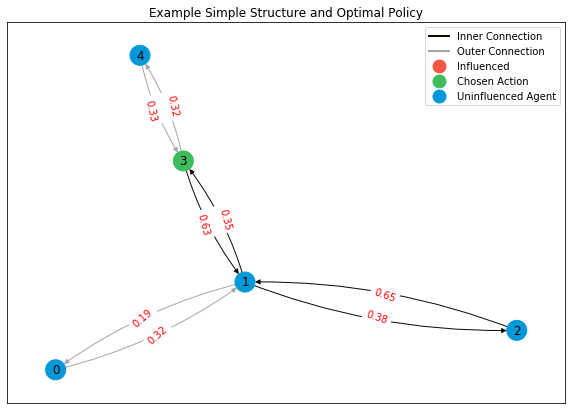

In [16]:
test_state = 20

action_nodes = np.zeros(len(env.agent_ids), dtype=int)
action_nodes[optimal_policy[test_state]] = 1

fig, ax = plt.subplots(figsize=(10,7))
env.plot_network_graph(influenced = env.state_space[test_state], action_nodes=action_nodes, ax=ax)
ax.set_title("Example Simple Structure and Optimal Policy")
ax.legend(handles=custom_legend2)
plt.savefig('../data/images/simple_network_mdp_solved2.png')
plt.show()


## Test Problem 2 - Inner Circle, Multiple Groups

In [4]:
agents = [
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5)
]

# Add some connections (only use inner circle):
agents[0].inner_circle.extend([agents[3].id, agents[4].id, agents[5].id])
agents[3].inner_circle.append(agents[0].id)
agents[4].inner_circle.append(agents[0].id)
agents[5].inner_circle.append(agents[0].id)

agents[1].inner_circle.extend([agents[6].id, agents[7].id])
agents[6].inner_circle.append(agents[1].id)
agents[7].inner_circle.append(agents[1].id)

agents[2].inner_circle.extend([agents[8].id])
agents[8].inner_circle.append(agents[2].id)

# - REMINDER - Do we want to have connections automatically propagate both ways when specified?

# Build simulation environment:
env = Environment(agents, seed=182)
print(env)


<Environment with 0/9 informed agents>


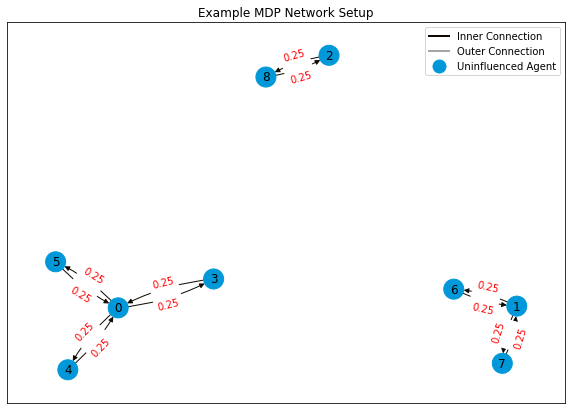

In [12]:
fig, ax2 = plt.subplots(figsize=(10,7))
env.plot_network_graph(ax=ax2)
ax2.set_title("Example MDP Network Setup")
ax2.legend(handles=custom_legend1)
plt.savefig('../data/images/discontinuous_network_example1.png')
plt.show()

In [6]:
env.update_transition_matrix(n_selected=1)


# Initialize a policy and MDP problem setup
initial_policy = np.zeros(len(env.state_space), dtype=int)
rewards = initialize_rewards(env.state_space)
values = initialize_values(env.state_space)

optimal_policy = policy_iteration(env, initial_policy, values, rewards, gamma = 0.99, epsilon=1e-8)


20 iterations run - max delta = 0.01077092941430724
40 iterations run - max delta = 4.303833594399009e-05
60 iterations run - max delta = 1.5079970960840683e-07


In [7]:
custom_legend2 = [Line2D([0], [0], color="#0f0a01", lw=2, label="Inner Connection"),
                Line2D([0], [0], color="#a5a6a9", lw=2, label="Outer Connection"),
                Line2D([0], [0], marker='o', color='w', markerfacecolor="#dbb700", 
                        markersize=15, label="Influenced and Chosen Action"),
                Line2D([0], [0], marker='o', color='w', markerfacecolor="#f45844", 
                        markersize=15, label="Influenced"),
                Line2D([0], [0], marker='o', color='w', markerfacecolor="#3dbd5d", 
                        markersize=15, label="Chosen Action"),
                Line2D([0], [0], marker='o', color='w', markerfacecolor="#0098d8", 
                        markersize=15, label="Uninfluenced")]

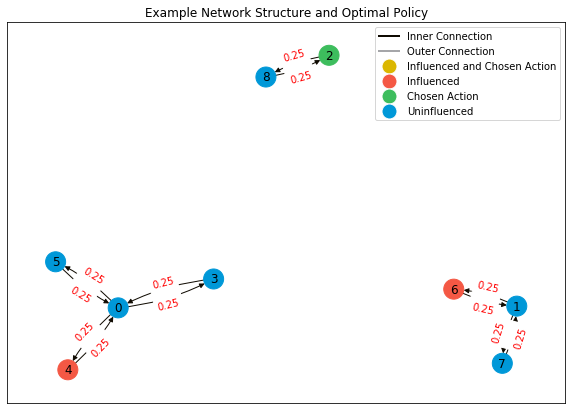

In [9]:
test_state = 20

action_nodes = np.zeros(len(env.agent_ids), dtype=int)
action_nodes[optimal_policy[test_state]] = 1

fig, ax = plt.subplots(figsize=(10,7))
env.plot_network_graph(influenced = env.state_space[test_state], action_nodes=action_nodes, ax=ax)
ax.set_title("Example Network Structure and Optimal Policy")
ax.legend(handles=custom_legend2)
plt.savefig('../data/images/discontinuous_network_mdp_solved1.png')
plt.show()

## Test Problem 3 - Inner Circle, Multiple Groups - Extend node

In [14]:
agents = [
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5),
    Agent(receptivity=0.5,persuasiveness=0.5)
]

# Add some connections (only use inner circle):
agents[0].inner_circle.extend([agents[3].id, agents[4].id, agents[5].id])
agents[3].inner_circle.append(agents[0].id)
agents[3].inner_circle.append(agents[9].id)
agents[9].inner_circle.append(agents[3].id)
agents[4].inner_circle.append(agents[0].id)
agents[5].inner_circle.append(agents[0].id)

agents[1].inner_circle.extend([agents[6].id, agents[7].id])
agents[6].inner_circle.append(agents[1].id)
agents[7].inner_circle.append(agents[1].id)

agents[2].inner_circle.extend([agents[8].id])
agents[8].inner_circle.append(agents[2].id)

# - REMINDER - Do we want to have connections automatically propagate both ways when specified?

# Build simulation environment:
env = Environment(agents, seed=182)
print(env)

<Environment with 0/10 informed agents>


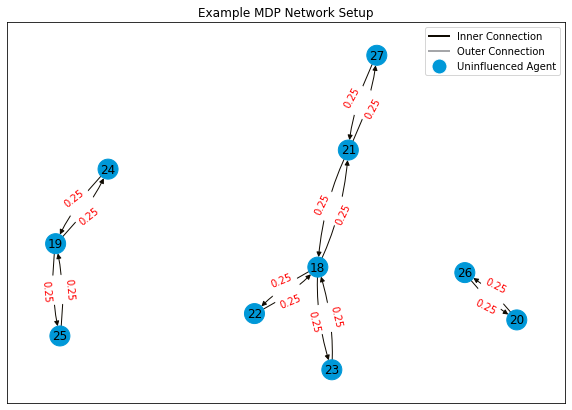

In [15]:
fig, ax3 = plt.subplots(figsize=(10,7))
env.plot_network_graph(ax=ax3)
ax3.set_title("Example MDP Network Setup")
ax3.legend(handles=custom_legend1)
plt.savefig('../data/images/discontinuous_network_example2.png')
plt.show()

In [16]:
env.update_transition_matrix(n_selected=1)


# Initialize a policy and MDP problem setup
initial_policy = np.zeros(len(env.state_space), dtype=int)
rewards = initialize_rewards(env.state_space)
values = initialize_values(env.state_space)

optimal_policy = policy_iteration(env, initial_policy, values, rewards, gamma = 0.99, epsilon=1e-8)


20 iterations run - max delta = 0.017757478223588308
40 iterations run - max delta = 8.12946345636334e-05
60 iterations run - max delta = 3.0225222946711483e-07


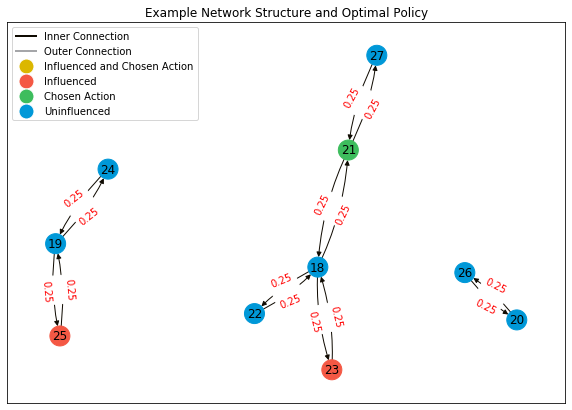

In [17]:
test_state = 20

action_nodes = np.zeros(len(env.agent_ids), dtype=int)
action_nodes[optimal_policy[test_state]] = 1

fig, ax4 = plt.subplots(figsize=(10,7))
env.plot_network_graph(influenced = env.state_space[test_state], action_nodes=action_nodes, ax=ax4)
ax4.set_title("Example Network Structure and Optimal Policy")
ax4.legend(handles=custom_legend2)
plt.savefig('../data/images/discontinuous_network_mdp_solved2.png')
plt.show()


## Add timings for Transition Generation


In [31]:
def instantiate_simple_environment(p_size):
    """ Simple linear network for testing times """
    agent_list = []
    for i in range(p_size):
        agent_list.append(Agent(receptivity=0.5,persuasiveness=0.5))
        if len(agent_list) > 1:
            agent_list[-1].inner_circle.append(agent_list[-2].id)
            agent_list[-2].inner_circle.append(agent_list[-1].id)
            
    env_test = Environment(agent_list, seed=182)
    return env_test

In [77]:
p_sizes = list(range(3,10))
n_selects = [1,2,3]
model_type = 'exhaustive_fast'
all_T_sizes = []
ex_fast_times = []

for n_sel in n_selects:
    times = []
    T_sizes = []
    for p_size in p_sizes:
        # Initialize environment 
        env_test = instantiate_simple_environment(p_size)
        
        # Time taken to generate the transition matrix for each p_size
        t0 = time.time()
        env_test.update_transition_matrix(n_selected=n_sel, model=model_type)
        times.append(time.time() - t0)

        T_sizes.append(env_test.T.shape)
    
    # Compile the times for each n_selected size
    ex_fast_times.append(times)
    all_T_sizes.append(T_sizes)


In [78]:
model_type = 'pruned'
pruned_times = []

for n_sel in n_selects:
    times = []
    for p_size in p_sizes:
        # Initialize environment 
        env_test = instantiate_simple_environment(p_size)
        
        # Time taken to generate the transition matrix for each p_size
        t0 = time.time()
        env_test.update_transition_matrix(n_selected=n_sel, model=model_type)
        times.append(time.time() - t0)

    # Compile the times for each n_selected size
    pruned_times.append(times)

In [79]:
problem_sizes = pd.DataFrame(all_T_sizes).T
ex_fast_results = pd.DataFrame(ex_fast_times).T
pruned_results = pd.DataFrame(pruned_times).T


In [80]:
# Rename columns and add row labels
problem_sizes = problem_sizes.rename(columns={0:"1_action", 1:"2_action",
                     2:"3_action"})
problem_sizes['network_size'] = p_sizes

ex_fast_results = ex_fast_results.rename(columns={0:"1_action", 1:"2_action",
                     2:"3_action"})
ex_fast_results['network_size'] = p_sizes

pruned_results = pruned_results.rename(columns={0:"1_action", 1:"2_action",
                     2:"3_action"})
pruned_results['network_size'] = p_sizes


In [81]:
ex_fast_results


,1_action,2_action,3_action,network_size
0,0.002344,0.001622,0.000659,3
1,0.008730,0.011856,0.007687,4
2,0.036924,0.069099,0.070584,5
3,0.155456,0.400059,0.533684,6
4,0.728141,2.190082,3.692590,7
5,3.288048,11.550527,23.045028,8
6,14.828884,59.513502,139.194751,9


In [82]:
pruned_results


,1_action,2_action,3_action,network_size
0,0.000432,0.000525,0.000509,3
1,0.000726,0.001020,0.000685,4
2,0.001956,0.002868,0.002404,5
3,0.003933,0.006366,0.008715,6
4,0.006385,0.017808,0.028680,7
5,0.015985,0.046176,0.090640,8
6,0.032712,0.120127,0.268128,9


In [83]:
problem_sizes


,1_action,2_action,3_action,network_size
0,"(3, 8, 8)","(3, 8, 8)","(1, 8, 8)",3
1,"(4, 16, 16)","(6, 16, 16)","(4, 16, 16)",4
2,"(5, 32, 32)","(10, 32, 32)","(10, 32, 32)",5
3,"(6, 64, 64)","(15, 64, 64)","(20, 64, 64)",6
4,"(7, 128, 128)","(21, 128, 128)","(35, 128, 128)",7
5,"(8, 256, 256)","(28, 256, 256)","(56, 256, 256)",8
6,"(9, 512, 512)","(36, 512, 512)","(84, 512, 512)",9


In [19]:
# fig, ax5 = plt.subplots(figsize=(10,7))
# env_test.plot_network_graph(ax=ax5)
# ax5.set_title("Example MDP Network Setup")
# ax5.legend(handles=custom_legend1)
# plt.savefig('../data/images/network_timing_example1.png')
# plt.show()
